In [1]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

Read catalog with Gaia DR2 data for the SDSS Stripe 82 region, see

https://github.com/dirac-institute/ivezic/blob/master/GaiaSprintUW2018/getStripe82fromGaiaDR2.ipynb


In [2]:
colnames = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra', 'pmdec']
gaia = Table.read('Stripe82_GaiaDR2.dat', format='ascii', names=colnames)
# developed code using Stripe82_GaiaDR2_1percent.dat
# a 1% subsample produced with
# cat Stripe82_GaiaDR2.dat | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01) print $0}' > Stripe82_GaiaDR2_1percent.dat
# gaia = Table.read('Stripe82_GaiaDR2_1percent.dat', format='ascii', names=colnames)

Read SDSS Stripe82 Standard Star Catalog, see
http://faculty.washington.edu/ivezic/sdss/catalogs/stripe82.html

In [3]:
colnames = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

sdss = Table.read('stripe82calibStars_v2.6.dat', format='ascii', names=colnames)

Match Gaia to SDSS, since here SDSS is much larger 

In [4]:
sdss_coords = SkyCoord(ra = sdss['ra']*u.degree, dec= sdss['dec']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['ra']*u.degree, dec= gaia['dec']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idx, d2d, d3d = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaia, sdss[idx]], table_names = ['gaia', 'sdss'])
gaia_sdss['sep_2d_arcsec'] = d2d.arcsec

# since it's matching gaia to sdss,
# the resulting catalog has the same length 
# as gaia ... 

Select good matches

In [5]:
# gaia sources that have a good (within 0.5 arcsec) sdss match 
flag = (gaia_sdss['sep_2d_arcsec'] < 0.5)   
gaia_matched = gaia_sdss[flag]
print(len(gaia_sdss))
print(len(gaia_matched))

2397440
894449


Text(0,0.5,'dDec')

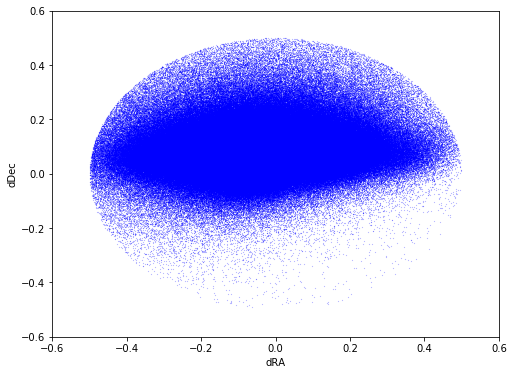

In [6]:
dra = 3600*(gaia_matched['ra_sdss'] - gaia_matched['ra_gaia']) 
ddec = 3600*(gaia_matched['dec_sdss'] - gaia_matched['dec_gaia'])  
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(dra, ddec, s=0.01, c='blue')
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.6,0.6)
ax.set_xlabel('dRA')
ax.set_ylabel('dDec') 

In [7]:
print(np.median(dra), np.median(ddec))
print(np.std(dra), np.std(ddec))

-0.0463507826424 0.0750284687013
0.159992536776 0.0878816773491


In [8]:
rMed = gaia_matched['r_mMed'] 
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed'] 
ra = gaia_matched['ra_gaia']
raW = np.where(ra > 180, ra-360, ra)   
flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19) & (gi>0) & (gi<3.0))
gaia_matchedOK = gaia_matched[flagOK]
print(len(gaia_matchedOK))

91020


Text(0,0.5,'SDSS(r-i)')

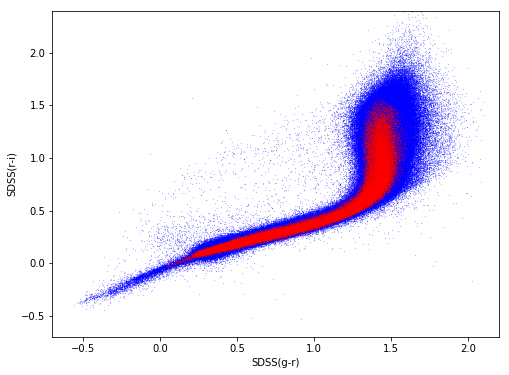

In [9]:
gr = gaia_matched['g_mMed'] - gaia_matched['r_mMed']
ri = gaia_matched['r_mMed'] - gaia_matched['i_mMed']
grOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['r_mMed']
riOK = gaia_matchedOK['r_mMed'] - gaia_matchedOK['i_mMed']
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gr, ri, s=0.01, c='blue')
ax.scatter(grOK, riOK, s=0.01, c='red')
ax.set_xlim(-0.7,2.2)
ax.set_ylim(-0.7,2.4)
ax.set_xlabel('SDSS(g-r)')
ax.set_ylabel('SDSS(r-i)')

Text(0,0.5,'Gaia G - SDSS r')

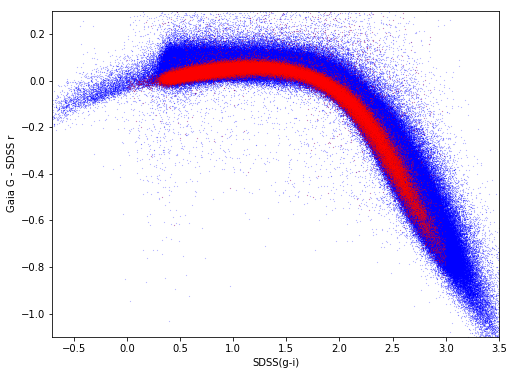

In [10]:
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
Gr = gaia_matched['Gmag'] - gaia_matched['r_mMed']
giOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed']
GrOK = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed']
# plot
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(gi, Gr, s=0.01, c='blue')
ax.scatter(giOK, GrOK, s=0.01, c='red')
ax.set_xlim(-0.7,3.5)
ax.set_ylim(-1.1,0.3)
ax.set_xlabel('SDSS(g-i)')
ax.set_ylabel('Gaia G - SDSS r')

In [11]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = 0 
            sigGbin[i] = 0 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [12]:
Gr = gaia_matched['Gmag'] - gaia_matched['r_mMed']
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
GrOK = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed']
giOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed']
# medians
#xBin, nPts, medianBin, sigGbin = fitMedians(gi, Gr, -0.7, 4.0, 47, 0)
#xBinOK, nPtsOK, medianBinOK, sigGbinOK = fitMedians(giOK, GrOK, -0.2, 3.2, 34, 0)
xBin, nPts, medianBin, sigGbin = fitMedians(gi, Gr, 0.0, 2.7, 30, 1)
xBinOK, nPtsOK, medianBinOK, sigGbinOK = fitMedians(giOK, GrOK, 0.0, 2.7, 30, 0)

#print(xBin, nPts, medianBin, sigGbin)
medOK1 = medianBin[(xBin>2)&(xBin<3)]
medOK2 = medianBinOK[(xBinOK>2)&(xBinOK<3)]
dmedOK = medOK2 - medOK1
#print(dmedOK)
# print(xBin, medianBin)

median: 0.0333762397766


In [13]:
# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(data, theta, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(data, degree, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(data, theta, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)


In [14]:
# this function computes a linear combination of 4 functions
# given parameters theta
def linear_fit(coeffs, x, w, y, z):
    ffit = coeffs[0]*x + coeffs[1]*w + coeffs[2]*y + coeffs[3]*z 
    return ffit

# compute the data log-likelihood given a model
def logLlin(dataL, coeffs, model=linear_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, w, y, z, f, sigma_f = dataL
    f_fit = model(coeffs, x, w, y, z)
    return sum(stats.norm.logpdf(*args)
               for args in zip(f, f_fit, sigma_f))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_lintheta(dataL, degree=4, model=linear_fit):
    coeffs_0 = degree * [0]
    neg_logLlin = lambda coeffs: -logLlin(dataL, coeffs, model)
    return optimize.fmin_bfgs(neg_logLlin, coeffs_0, disp=False)


In [15]:
GmagOK = gaia_matchedOK['Gmag']
GG = 25.525-2.5*np.log10(gaia_matchedOK['flux'])
dG = GG - GmagOK 
print(np.median(dG))
print(np.std(dG))
print(np.median(gaia_matchedOK['flux']))

-0.163365724663
5.49208851312e-07
1485.4637121


In [16]:
ra = gaia_matchedOK['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
gi = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed']
rMed = gaia_matchedOK['r_mMed']
flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19) & (gi>0) & (gi<3.0))
Gmag = gaia_matchedOK['Gmag']
flagOK2 = (flagOK & (Gmag > 16) & (Gmag < 16.5))
gaia_matchedOK2 = gaia_matchedOK[flagOK2]
print(len(gaia_matchedOK))
print(len(gaia_matchedOK2))

91020
9465


In [17]:
fluxGaia = gaia_matchedOK2['flux']
fluxGaiaErr = gaia_matchedOK2['fluxErr']
gFlux = 10**(0.4*gaia_matchedOK2['g_mMean'])
rFlux = 10**(0.4*gaia_matchedOK2['r_mMean'])
iFlux = 10**(0.4*gaia_matchedOK2['i_mMean'])
zFlux = 10**(0.4*gaia_matchedOK2['z_mMean'])
dataL = np.array([gFlux, rFlux, iFlux, zFlux, fluxGaia, fluxGaiaErr])
x, w, y, z, f, sigma_f = dataL
coeffs1 = best_lintheta(dataL)
ffit = linear_fit(coeffs1, x, w, y, z)
dmag = -2.5*np.log10(ffit/f) 

In [18]:
print(np.median(dmag))
print(np.std(dmag))
print(coeffs1)
print(np.median(f))
print(np.std(f))
print(np.median(ffit))
print(np.std(ffit))

0.0756049007342
0.270245581101
[ 0.00026133 -0.00098024  0.00392364 -0.00128479]
5818.30736502
733.24284795
5424.57707976
686.156232773


In [19]:
fluxGaia = gaia_matchedOK['flux']
gFlux = 10**(0.4*gaia_matchedOK['g_mMean'])
rFlux = 10**(0.4*gaia_matchedOK['r_mMean'])
iFlux = 10**(0.4*gaia_matchedOK['i_mMean'])
zFlux = 10**(0.4*gaia_matchedOK['z_mMean'])
ffitOK = linear_fit(coeffs1, gFlux, rFlux, iFlux, zFlux)
dmagOK = -2.5*np.log10(ffitOK/fluxGaia) 
print(np.median(dmagOK))
print(np.std(dmagOK))

-2.87874949103
1.6305691662


In [20]:
data = np.array([xBin, medianBin, sigGbin])
# data = np.array([xBinOK, medianBinOK, sigGbinOK])
# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(data,2)
theta2 = best_theta(data,3)
theta3 = best_theta(data,4)
# generate best fit lines on a fine grid 
xfit = np.linspace(-1.1, 4.3, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)

In [21]:
# and compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
x = giOK
y = GrOK
sigma_y = 0*GrOK + 0.02
Ndata = giOK.size
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) 
# the number of fitted parameters is 3, 4, 5
chi2dof1 = chi21/(Ndata - 3)
chi2dof2 = chi22/(Ndata - 4)
chi2dof3 = chi23/(Ndata - 5) 

In [22]:
print("CHI2:")
print('   best linear model:', chi21)
print('best quadratic model:', chi22)
print( '    best cubic model:', chi23)
print( "CHI2 per degree of freedom:")
print( '   best linear model:', chi2dof1)
print( 'best quadratic model:', chi2dof2)
print( '    best cubic model:', chi2dof3)

CHI2:
   best linear model: 1085801.30495
best quadratic model: 702001.068959
    best cubic model: 706912.787527
CHI2 per degree of freedom:
   best linear model: 11.9296538553
best quadratic model: 7.71294133953
    best cubic model: 7.76699211698


In [23]:
Gr = gaia_matched['Gmag'] - gaia_matched['r_mMed']
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
GrOK = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed']
giOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed']

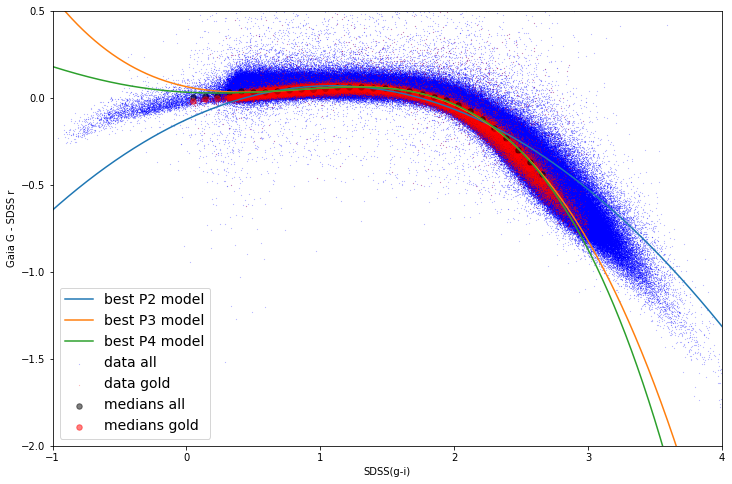

In [24]:
# Plot a (gaia - r)  vs (g-i)  for photometric transformation
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(gi, Gr, s=0.01, c='blue', label='data all')
ax.scatter(giOK, GrOK, s=0.01, c='red', label='data gold')
# medians
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.5, label='medians all')
ax.scatter(xBinOK, medianBinOK, s=30.0, c='red', alpha=0.5, label='medians gold')
ax.set_xlim(-1,4)
ax.set_ylim(-2.0,0.5)
ax.set_xlabel('SDSS(g-i)')
ax.set_ylabel('Gaia G - SDSS r')
#ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best P2 model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best P3 model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best P4 model')
ax.legend(loc='best', fontsize=14)

In [25]:
theta2

array([ 0.0644284 , -0.16440366,  0.25599561, -0.09994182])

In [26]:
# GrModel = [ 0.0644284 , -0.16440366,  0.25599561, -0.09994182]
GrModel = sum(t * gi ** n for (n, t) in enumerate(theta3))
GrResid = Gr - GrModel
xBinM, nPtsM, medianBinM, sigGbinM = fitMedians(gi, GrResid, -0.7, 4.0, 47, 0)

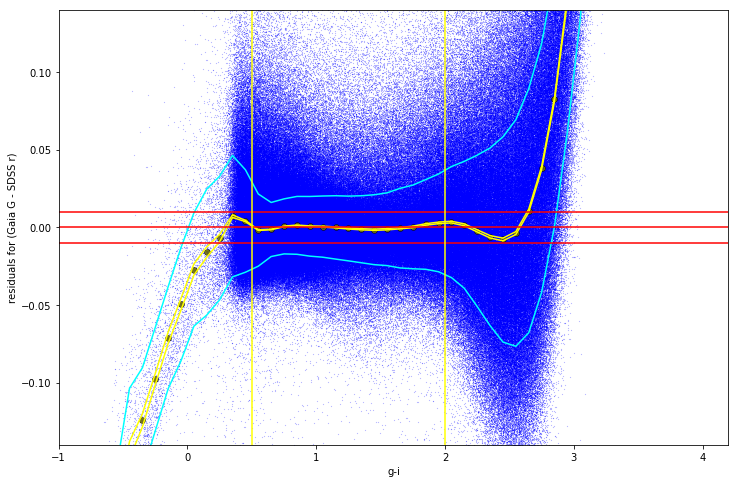

In [27]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(gi, GrResid, s=0.01, c='blue')
# medians
ax.scatter(xBinM, medianBinM, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinM, medianBinM, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinM + 2*sigGbinM
TwoSigM = medianBinM - 2*sigGbinM 
ax.plot(xBinM, TwoSigP, c='yellow')
ax.plot(xBinM, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsM) / np.sqrt(np.pi/2) * sigGbinM
rmsP = medianBinM + rmsBin
rmsM = medianBinM - rmsBin
ax.plot(xBinM, rmsP, c='cyan')
ax.plot(xBinM, rmsM, c='cyan')
ax.set_xlim(-1,4.2)
ax.set_ylim(-0.14,0.14)
ax.set_xlabel('g-i')
ax.set_ylabel('residuals for (Gaia G - SDSS r)')
xL = np.linspace(-10,10)
ax.plot(xL, 0*xL+0.00, c='red')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
ax.plot(0*xL+0.5, xL, c='yellow')
ax.plot(0*xL+2.0, xL, c='yellow')

In [28]:
medOK = medianBinM[(xBinM>0.5)&(xBinM<2.0)]

In [29]:
print(medOK)

[ -1.75566474e-03  -1.37764988e-03   6.26323534e-04   1.28733336e-03
   6.80002640e-04   4.87207494e-04  -3.07361751e-05  -7.22345857e-04
  -1.22131919e-03  -1.51483525e-03  -1.19574985e-03  -5.05182094e-04
   2.69736414e-04   1.88143489e-03   2.88319701e-03]


In [30]:
np.median(medOK)

-3.0736175101610252e-05

In [31]:
np.std(medOK)

0.0013075715670457203

In [32]:
np.max(medOK)

0.0028831970094238546

In [33]:
np.min(medOK)

-0.0017556647351399945

In [34]:
ra = gaia_matched['ra_gaia']
raW = np.where(ra > 180, ra-360, ra)   
raOK = gaia_matchedOK['ra_gaia']
raWok = np.where(raOK > 180, raOK-360, raOK)   
residOK = GrResid[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
rMed = gaia_matched['r_mMed'] 
magOK = rMed[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
gaiaG = gaia_matched['Gmag']
GOK = gaiaG[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
print(np.median(residOK))
print(np.std(residOK))

0.00152068094982
0.0541848512053


In [35]:
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(magOK, residOK, 14, 20.5, 65, 0)

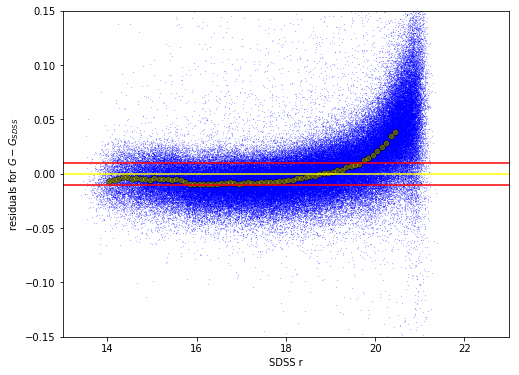

In [36]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(magOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
ax.set_xlim(13,23)
ax.set_ylim(-0.15,0.15)
ax.set_xlabel('SDSS r')
ax.set_ylabel('residuals for $G-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [37]:
print(medianBinMg)

[-0.00640725 -0.00547658 -0.00468033 -0.0032704  -0.00345852 -0.00445675
 -0.00426653 -0.00480642 -0.00497119 -0.0055401  -0.00411163 -0.00487573
 -0.00503688 -0.00497042 -0.00545214 -0.00491348 -0.00553913 -0.0073856
 -0.00974883 -0.00984132 -0.00978193 -0.00923847 -0.00958011 -0.00907553
 -0.00927081 -0.00837645 -0.00859751 -0.00798832 -0.00865876 -0.00900544
 -0.00843035 -0.00802862 -0.00816073 -0.00891825 -0.00758427 -0.00745875
 -0.00806578 -0.00721081 -0.00692845 -0.00631747 -0.00560034 -0.00545973
 -0.00432197 -0.00358681 -0.00337852 -0.002084   -0.00205377 -0.00069189
  0.00026568  0.00030215  0.00130502  0.00305241  0.00384375  0.00641248
  0.0068602   0.00790015  0.00923824  0.01219953  0.01457516  0.01717881
  0.02046845  0.02427223  0.02858417  0.03438433  0.0385995 ]


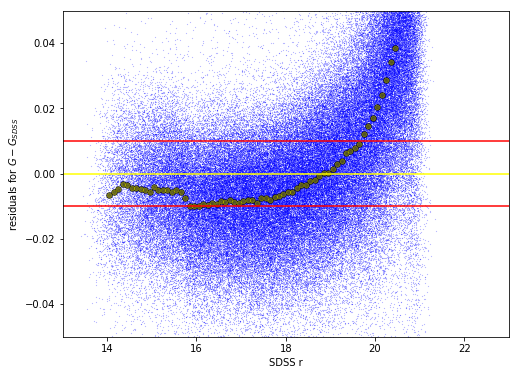

In [38]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(magOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
ax.set_xlim(13,23)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('SDSS r')
ax.set_ylabel('residuals for $G-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [39]:
print(magOK.size)
print(GOK.size)
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GOK, residOK, 14, 20.5, 130, 0)

147451
147451


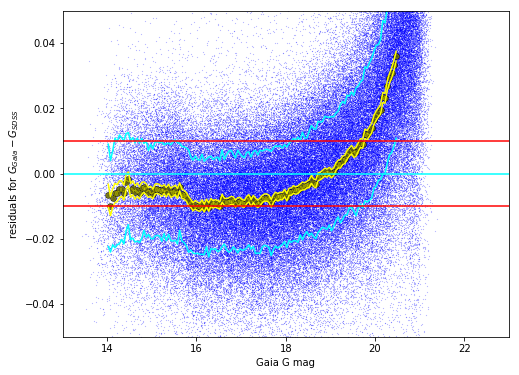

In [40]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GOK, residOK, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinMg + 2*sigGbinMg 
TwoSigM = medianBinMg - 2*sigGbinMg 
ax.plot(xBinMg, TwoSigP, c='yellow')
ax.plot(xBinMg, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsMg) / np.sqrt(np.pi/2) * sigGbinMg 
rmsP = medianBinMg + rmsBin
rmsM = medianBinMg - rmsBin
ax.plot(xBinMg, rmsP, c='cyan')
ax.plot(xBinMg, rmsM, c='cyan')
ax.set_xlim(13,23)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('residuals for $G_{Gaia}-G_{SDSS}$ ')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='cyan')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

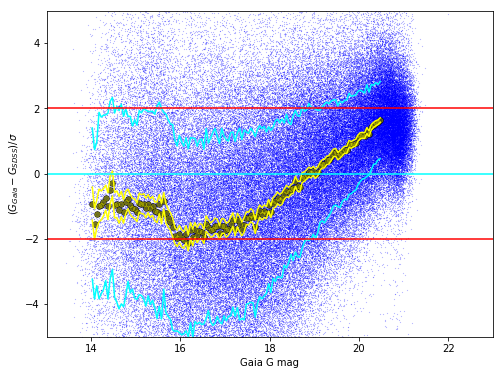

In [41]:
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed']
ra = gaia_matched['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
flux = gaia_matched['flux']
fluxErr = gaia_matched['fluxErr']
fluxOK = flux[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
fluxErrOK = fluxErr[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
rBandErr = gaia_matched['r_mErr']
rBandErrOK = rBandErr[(gi>0.4)&(gi<2.0)&(raW>-10)&(raW<50)]
## Gaia's errors underestimated by a factor of ~2
sigma = np.sqrt((2*fluxErrOK/fluxOK)**2 + 1*rBandErrOK**2)
chi = residOK / sigma
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GOK, chi, 14, 20.5, 130, 0)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GOK, chi, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.8)
ax.scatter(xBinMg, medianBinMg, s=20.0, c='yellow', alpha=0.3)
TwoSigP = medianBinMg + 2*sigGbinMg 
TwoSigM = medianBinMg - 2*sigGbinMg 
ax.plot(xBinMg, TwoSigP, c='yellow')
ax.plot(xBinMg, TwoSigM, c='yellow')
rmsBin = np.sqrt(nPtsMg) / np.sqrt(np.pi/2) * sigGbinMg 
rmsP = medianBinMg + rmsBin
rmsM = medianBinMg - rmsBin
ax.plot(xBinMg, rmsP, c='cyan')
ax.plot(xBinMg, rmsM, c='cyan')
ax.set_xlim(13,23)
ax.set_ylim(-5,5)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('($G_{Gaia}-G_{SDSS}$)/$\sigma$')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='cyan')
ax.plot(xL, 0*xL+2, c='red')
ax.plot(xL, 0*xL-2, c='red')

In [42]:
Gerr = fluxErrOK/fluxOK
print(np.median(Gerr))
print(np.median(rBandErrOK))

0.00246728417679
0.006


In [43]:
residOK2 = residOK[(magOK>15)&(magOK<16)]
print(np.median(residOK2))
mm = medianBinMg[(xBinMg>15)&(xBinMg<16)]
xx = xBinMg[(xBinMg>15)&(xBinMg<16)]
print(mm)
print(xx)
print("transition at G ~ 15.6")

-0.00633529032435
[-1.18155885 -0.8892976  -0.93349141 -0.924313   -1.05189909 -0.91626058
 -1.05218531 -0.98269273 -1.15089686 -1.18502626 -0.93582223 -1.22467055
 -0.82903836 -1.21864608 -1.36103662 -1.46741164 -1.64239422 -1.9019818
 -1.98200887 -1.84474142]
[ 15.025  15.075  15.125  15.175  15.225  15.275  15.325  15.375  15.425
  15.475  15.525  15.575  15.625  15.675  15.725  15.775  15.825  15.875
  15.925  15.975]
transition at G ~ 15.6


In [44]:
## conclusions
# 1) select:(-10 < RA < 50) & (16 < SDSSr < 19) & (0.4< g-i < 2.0)
thetaFinal = theta3
print(thetaFinal)

[ 0.0326888  -0.04273989  0.09936676 -0.0193615  -0.01419077]


In [45]:
rMed = gaia_matched['r_mMed'] 
gi = gaia_matched['g_mMed'] - gaia_matched['i_mMed'] 
ra = gaia_matched['ra_gaia'] 
raW = np.where(ra > 180, ra-360, ra)
flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<18) & (gi>0) & (gi<3.0))
# flagOK = ((raW > -10) & (raW < 50) & (rMed>16) & (rMed<19) & (gi>0) & (gi<3.0))
gaia_matchedOK = gaia_matched[flagOK]
print(len(gaia_matchedOK))

51658


In [46]:
giOK = gaia_matchedOK['g_mMed'] - gaia_matchedOK['i_mMed'] 
GrOK = gaia_matchedOK['Gmag'] - gaia_matchedOK['r_mMed'] 
GmagOK = gaia_matchedOK['Gmag'] 
GrModel = sum(t * giOK ** n for (n, t) in enumerate(theta3))
GrResid = GrOK - GrModel
print(np.median(GrResid))
print(np.std(GrResid))
print(np.min(GrResid))
print(np.max(GrResid))

-0.0106371239663
0.0534794617562
-0.516665524222
2.92007609161


In [47]:
#xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GmagOK, GrResid, 16, 18.8, 14, 0)
xBinMg, nPtsMg, medianBinMg, sigGbinMg = fitMedians(GmagOK, GrResid, 16, 17.8, 14, 0)

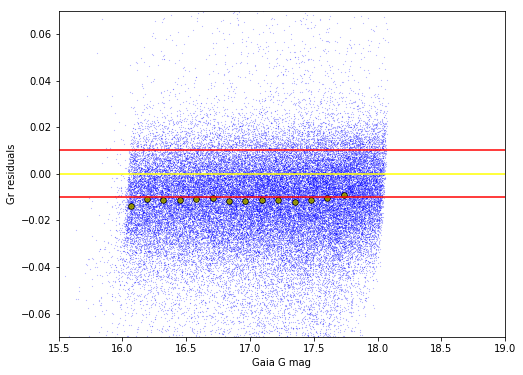

In [48]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(GmagOK, GrResid, s=0.01, c='blue')
# medians
ax.scatter(xBinMg, medianBinMg, s=30.0, c='black', alpha=0.9)
ax.scatter(xBinMg, medianBinMg, s=15.0, c='yellow', alpha=0.5)
ax.set_xlim(15.5,19)
ax.set_ylim(-0.07,0.07)
ax.set_xlabel('Gaia G mag')
ax.set_ylabel('Gr residuals')
xL = np.linspace(-10,30)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [49]:
print(np.median(medianBinMg))
print(np.std(medianBinMg))

-0.0112031660647
0.000988086618755


In [50]:
GrResidN = GrResid - np.median(medianBinMg)

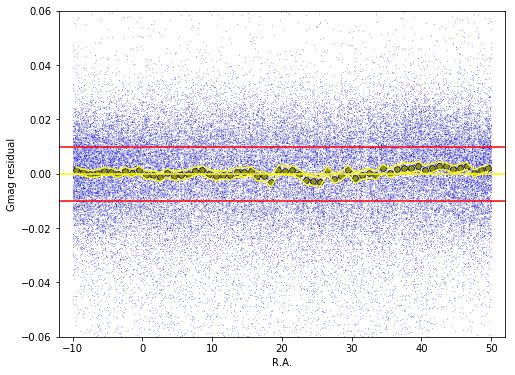

In [56]:
ra = gaia_matchedOK['ra_sdss'] 
raW = np.where(ra > 180, ra-360, ra)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raW, GrResidN, s=0.01, c='blue')
ax.set_xlim(-12,52)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('R.A.')
ax.set_ylabel('Gmag residual')
xBin, nPts, medianBin, sigGbin = fitMedians(raW, GrResidN, -10, 50, 60, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')

In [52]:
print(np.median(medianBin))
print(np.std(medianBin))
print(np.min(medianBin))
print(np.max(medianBin))

0.000372719044258
0.00141635534689
-0.00304668549579
0.00300580948342


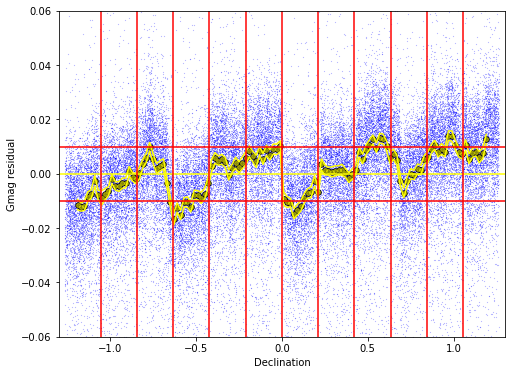

In [53]:
dec = gaia_matchedOK['dec_sdss'] 
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(dec, GrResidN, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('Declination')
ax.set_ylabel('Gmag residual')
xBin, nPts, medianBin, sigGbin = fitMedians(dec, GrResidN, -1.2, 1.2, 120, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
for i in range(1,12):
    decCol = -1.2655 + i*0.2109
    ax.plot(0*xL+decCol, xL, c='red')

In [54]:
print(np.median(medianBin))
print(np.std(medianBin))
print(np.min(medianBin))
print(np.max(medianBin))

0.00159981110349
0.00767629006732
-0.0167155397745
0.0140601237665
